In [1]:
# global imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import pandas as pd
import tensorflow as tf

In [2]:
# instantiate pathway variables
projectDir='D:\mattp\Documents\School\SeniorYear\DataAnalysis\Homework\PMAnalysisHW'

KHDir = projectDir + '\KHresamplePAandWthr-1217_0118.csv'
MADir = projectDir + '\MAresamplePAandWthr-1217_0118.csv'
#USDir = projectDir + '\USresamplePAandWthr-1217_0118.csv'

# read in data
KHData = pd.read_csv(KHDir,header=0)
MAData = pd.read_csv(MADir,header=0)
#USData = pd.read_csv(USDir,header=0)

#Data = pd.concat([KHData,MAData], axis=0)
Data = KHData

In [3]:
# create useful data structures
from sklearn import preprocessing
# create labelencoder object
le = preprocessing.LabelEncoder()

# encode wind direction
encodedWindDir = le.fit_transform(Data.windMPH)
encodedWindDirDf = pd.DataFrame(encodedWindDir)

# process datetime
import datetime as dt
dtParsed = [0 for i in range(Data.shape[0])]
for i in range(Data.shape[0]):
    dtParsed[i] = dt.datetime.strptime(Data.datetime.values[i], '%Y-%m-%d %H:%M:%S')

# enumerate time of day
dtEnumerated = [0 for i in range(Data.shape[0])]
for i in range(Data.shape[0]):
    dtEnumerated[i] = dtParsed[i].hour*3600 + dtParsed[i].minute*60 + dtParsed[i].second
dtEmumeratedDf = pd.DataFrame(dtEnumerated)

# drop out bad rows
Data.reset_index(drop=True, inplace=True)
    
# combine features and output for scaling
features = pd.concat([dtEmumeratedDf, encodedWindDirDf, Data.temperatureF, Data.dewpointF, Data.humidityPCNT, Data.wind_speedMPH, Data.wind_gustsMPH, Data.pressureIN, Data.precipIN,Data.PM25],axis=1)

In [4]:
# scale features
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
scaled = sc.fit_transform(features)

# seperate scaled data(X) and output(y)
X = scaled[:,0:9]
y = np.asarray(features)[:,9]

In [5]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
# instantiate regressor model
from keras import Sequential
from keras.layers import Dense
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(100, input_dim=9, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(100, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(75, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(50, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(1, kernel_initializer='normal'))
    regressor.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae','accuracy'])
    return regressor

# select batch size, epochs, validation set size
from keras.wrappers.scikit_learn import KerasRegressor
regressor = KerasRegressor(build_fn=build_regressor, batch_size=64,epochs=50,validation_split=0.2)

Train on 30400 samples, validate on 7600 samples
Epoch 1/50
30400/30400 [==============================] - 4s 146us/step - loss: 197.6285 - mean_absolute_error: 10.2441 - acc: 0.0014 - val_loss: 173.9424 - val_mean_absolute_error: 9.9067 - val_acc: 9.2105e-04
Epoch 2/50
30400/30400 [==============================] - 3s 92us/step - loss: 175.4728 - mean_absolute_error: 9.7684 - acc: 8.8816e-04 - val_loss: 173.1941 - val_mean_absolute_error: 10.0467 - val_acc: 7.8947e-04
Epoch 3/50
30400/30400 [==============================] - 3s 104us/step - loss: 174.7814 - mean_absolute_error: 9.7350 - acc: 9.8684e-04 - val_loss: 171.4427 - val_mean_absolute_error: 9.7063 - val_acc: 9.2105e-04
Epoch 4/50
30400/30400 [==============================] - 3s 94us/step - loss: 173.4918 - mean_absolute_error: 9.6883 - acc: 8.5526e-04 - val_loss: 169.6513 - val_mean_absolute_error: 9.5654 - val_acc: 0.0013
Epoch 5/50
30400/30400 [==============================] - 3s 98us/step - loss: 171.4315 - mean_absolute

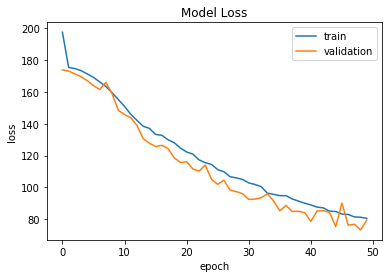

In [18]:
# train model
log = regressor.fit(X_train,y_train)

# loss plot
plt.plot(log.history['loss'])
plt.plot(log.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
# make predictions
y_pred = regressor.predict(X_test)

In [19]:
# plot predicitons
# configure scatterplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5.5))
fig.subplots_adjust(wspace=0.25)
ax1.scatter(y_test, y_pred,5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax1.set_xlabel('Measured')
ax1.set_ylabel('Predicted')
ax1.set_ylim([0,0.3])
ax1.set_xlim([0,0.31])
ax1.set_title('Measured vs Prediction Scatterplot')

# configure 2d histogram
# cmap initialization
#heatMap = cm.get_cmap('hot_r',9500)
#newColors = heatMap(np.linspace(0, 1,9500))
#grey = np.array([0.941, 0.941, 0.941,1])
#newColors[1:19,:] = grey
#newHeatMap = ListedColormap(newColors)
# histogram initialization
hist = ax2.hist2d(y_test,y_pred,bins=[10,10],cmap='hot_r')
ax2.set_ylim([0,0.3])
ax2.set_xlim([0,0.27])
fig.colorbar(hist[3], ax = ax2)
ax2.set_xlabel('Measured')
ax2.set_ylabel('Predicted')
ax2.set_title('Measured vs Prediction Histogram')

plt.show()

ValueError: Image size of 294132x61559 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x396 with 3 Axes>